In [277]:
import matplotlib.pyplot as plt
import nolitsa
import numpy as np
from scipy import spatial
from scipy import stats
from statsmodels.tsa import stattools
import time 
from tqdm.notebook import tqdm

## 1. Simulating the Lorenz Attractor

The equations that govern the Lorenz attractor are:

$$\frac{dx}{dt} = \sigma(y - x)$$

$$\frac{dy}{dt} = x(\rho - z) - y$$

$$\frac{dz}{dt} = xy - \beta z$$

where we set $\beta = \frac{8}{3}$ and $\sigma = 10$ based on https://itp.uni-frankfurt.de/~gros/Vorlesungen/SO/simulation_example/.

In [278]:
# dt, T are in milliseconds
def simulate_lorenz(rho, beta=8/3, sigma=10, dt=0.0001, T = 2, initial_condition=None):
    if initial_condition is None:
        initial_condition = np.random.normal(size=(3,))
    
    time_vals = np.arange(0, T + dt, dt)
    pts = np.zeros((len(time_vals), 3))
    pts[0] = initial_condition
    
    for t in range(1, len(time_vals)):
        x, y, z = pts[t - 1]
        dx = sigma*(y - x)
        dy = x*(rho - z) - y
        dz = x*y - beta*z
        
        x += dx*dt
        y += dy*dt
        z += dz*dt
        
        pts[t] = [x, y, z]
    
    return pts, time_vals

In [279]:
dt = 0.01
T = 50
lorenz_pts, time_vals = simulate_lorenz(28, dt=dt, T=T, initial_condition=[0.62225717, -0.08232857, 30.60845379])

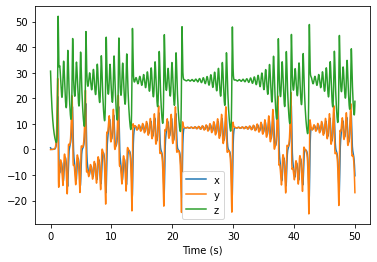

In [280]:
plt.plot(time_vals, lorenz_pts[:, 0], label='x')
plt.plot(time_vals, lorenz_pts[:, 1], label='y')
plt.plot(time_vals, lorenz_pts[:, 2], label='z')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

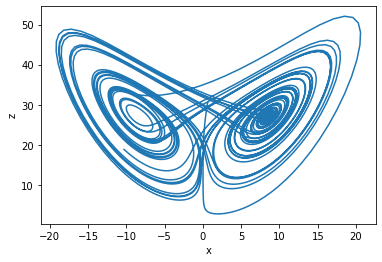

In [281]:
plt.plot(lorenz_pts[:, 0], lorenz_pts[:, 2])
plt.xlabel('x')
plt.ylabel('z')
plt.show()

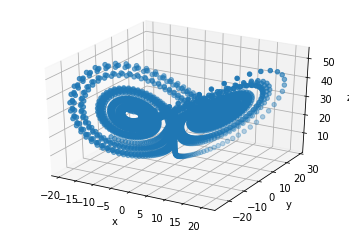

In [282]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(lorenz_pts[:, 0], lorenz_pts[:, 1], lorenz_pts[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

## 2. Picking a Time Lag $\tau$

In [283]:
def autocorr(x, max_lag=None, progress_bar=False):
    n = len(x)
    if max_lag is None:
        max_lag = n - 1
    
    cov = np.zeros(max_lag + 1)
    sample_mean = np.mean(x)
    if progress_bar:
        iterator = tqdm(total = max_lag + 1)
    for lag in range(max_lag+1):
        cov[lag] = np.mean((x[lag:] - sample_mean)*(x[:n - lag] - sample_mean))
        if progress_bar:
            iterator.update()
    if progress_bar:
        iterator.close()
    
    corr = np.zeros(max_lag + 1)
    for lag in range(max_lag + 1):
        corr[lag] = cov[lag]/cov[0]
    
    return corr

In [284]:
signal = lorenz_pts[:, 0]

In [285]:
acorr = autocorr(signal, max_lag=None, progress_bar=True)

In [291]:
# tau = np.argmax(acorr < 0)
# print(f"The chosen time lag tau = {tau} ({tau*dt:.2f} seconds)")

The chosen time lag tau = 658 (6.58 seconds)


In [292]:
# tau = np.argmax(np.abs(stattools.pacf(signal, nlags=500, method='ldb')) < 2/np.sqrt(len(signal)))
# tau

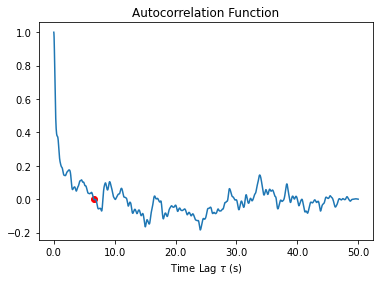

In [294]:
# plt.plot(acorr)
plt.plot(stattools.acf(signal, adjusted=False, nlags=len(signal), fft=False))
# plt.plot(stattools.pacf(signal, nlags=500, method='ldb'))
plt.title('Autocorrelation Function')
plt.xlabel(r'Time Lag $\tau$ (s)')
xticks = plt.xticks()[0][1:-1]
plt.xticks(xticks, xticks*dt)
plt.scatter(tau, 0, c='red')
plt.show()

## 3. Pick an Embedding Dimension

To implement false nearest neighbours:

$$X_{\text{fnn}}(r) = \frac{\sum_{n=1}^{N - m-1} \Theta \left(\frac{\vert x^{(m+1)}_n - x^{(m+1)}_{k(n)} \vert}{\vert x^{(m)}_n - x^{(m)}_{k(n)} \vert} - r\right)\Theta\left(\frac{\sigma}{r} - \vert x^{(m)}_n - x^{(m)}_{k(n)} \vert\right)}{\sum_{n=1}^{N - m-1}\Theta\left(\frac{\sigma}{r} - \vert x^{(m)}_n - x^{(m)}_{k(n)} \vert\right)}$$

where $r$ is a threshold, $m$ is the embedding demension, $k(n)$ is the nearest neighbour to point $n$, and $\Theta$ is a step function.

Or, alternatively, compute

$$R_i = \frac{\vert x^{(m)}_{n+1} - x^{(m)}_{k(n) + 1} \vert}{\vert x^{(m)}_n - x^{(m)}_{k(n)} \vert}$$

and declare a false nearest neighbor if $R_i$ is greater than some threshold $r$.

In [295]:
def embed_signal(x, m, tau):
    embedding = np.zeros((len(x) - m*tau, m))
    for n in range(len(x) - m*tau):
        for mult in range(m):
#             print(f"item [{n}, {mult}] = x[{n + mult*tau}]")
            embedding[n, mult] = x[n + mult*tau]
    
    return embedding

In [296]:
def get_nn_indices(pts, p=2):
    kdTree = spatial.cKDTree(pts, leafsize=100)
    nn = kdTree.query(pts, k=2, p=p)
    nn_indices = nn[1][:, 1]
    min_dist = nn[0][:, 1]
    
    return nn_indices, min_dist

def get_metric(p, name=False):
    if p == 1:
        if name:
            return "cityblock"
        return spatial.distance.cityblock
    elif p == 2:
        if name:
            return "euclidean"
        return spatial.distance.euclidean
    elif p == np.Inf:
        if name:
            return "chebyshev"
        return spatial.distance.chebyshev
    else:
        if name:
            return "minkowski"
        return lambda u, v: scipt.distance.minkowski(u, v, p=p)

def calculate_fnn_stat(pts, nn_indices, r, p=2):
    metric = get_metric(p)
    
    N = pts.shape[0]
    nn_distances = []
    nn_next_step_distances = []
    
    for i in range(N-1):
        if nn_indices[i] + 1 < N:
            nn_distance = metric(pts[i], pts[nn_indices[i]])
            if nn_distance == 0:
                nn_distances.append(1)
                nn_next_step_distances.append(np.Inf)
            else:
                nn_distances.append(nn_distance)
                nn_next_step_distances.append(metric(pts[i+1], pts[nn_indices[i]+1]))
    nn_distances, nn_next_step_distances = np.array(nn_distances), np.array(nn_next_step_distances)
    ratios = nn_next_step_distances/nn_distances
    fraction_greater = np.sum(ratios > r)/len(ratios)
    return fraction_greater, ratios

In [297]:
p = 1
r = 10

M_vals = np.arange(1, 6)
fraction_fnn = np.zeros(M_vals.shape)

for i, m in enumerate(M_vals):
    embedding = embed_signal(signal, m, tau=tau)
    nn_indices, _ = get_nn_indices(embedding, p=p)
    fraction_greater, ratios = calculate_fnn_stat(embedding, nn_indices, r, p=p)
    fraction_fnn[i] = fraction_greater

In [298]:
m = 3
embedding = embed_signal(signal, m, tau=tau)

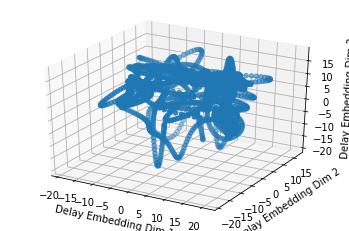

In [299]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
ax.set_xlabel('Delay Embedding Dim 1')
ax.set_ylabel('Delay Embedding Dim 2')
ax.set_zlabel('Delay Embedding Dim 3')
plt.show()

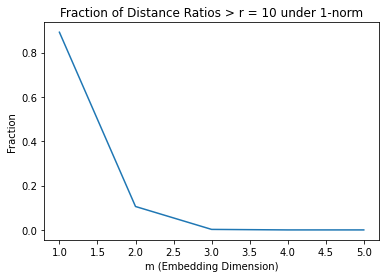

In [300]:
plt.plot(M_vals, fraction_fnn)
plt.xlabel('m (Embedding Dimension)')
plt.title(f'Fraction of Distance Ratios > r = {r} under {p}-norm')
plt.ylabel('Fraction')
plt.show()

## 4. Find Lyapunov Exponent

In [301]:
def get_index(i, j, N):
    if i > j:
        i
    return N * i + j - ((i + 2) * (i + 1)) // 2

def average_neighbor_distance(embedding, pairwise_dists, epsilon=15, max_delta=30, num_reference_pts=100, progress_bar=False, iterator=None):
    S = np.zeros(max_delta + 1)
    N = len(embedding)
    if progress_bar:
        iterator = tqdm(total=np.sum((N - np.arange(max_delta+1))*(N - np.arange(max_delta+1))))
    
    if num_reference_pts is None:
        reference_indices = np.random.choice(np.arange(N - max_delta), size=(N - max_delta,))
    else:
        reference_indices = np.random.choice(np.arange(N - max_delta), size=(num_reference_pts,))
    
    count = 0
    for i in reference_indices:
        neighbor_dist_sum = np.zeros(max_delta + 1)
        neighbor_dist_count = 0
        for j in range(N - max_delta):
            if pairwise_dists[i, j] < epsilon:
                neighbor_dist_count += 1
                for delta_n in range(max_delta + 1):
                    neighbor_dist_sum[delta_n] += pairwise_dists[i + delta_n, j + delta_n]
                
            if iterator is not None:
                iterator.update()
    
        if neighbor_dist_count != 0:
            S += np.log(neighbor_dist_sum/neighbor_dist_count)
            count += 1

    S /= count
    if iterator is not None and progress_bar:
        iterator.close()
    
    return S, np.arange(max_delta + 1)

def compute_average_neighbor_distance(signal, m_vals, epsilon_vals, max_delta=30, num_reference_pts=100, p=1, progress_bar=True):
    results = []
    total = 0
    if progress_bar:
        for m in m_vals:
            embedding = embed_signal(signal, m, tau=tau)
            N = len(embedding)
            if num_reference_pts is None:
                total += (N - max_delta)*(N - max_delta)*len(epsilon_vals)
            else:
                total += num_reference_pts*(N - max_delta)*len(epsilon_vals)
        iterator = tqdm(total = total)
        # iterator = tqdm(total = len(m_vals)*len(epsilon_vals))

    for m in m_vals:
        embedding = embed_signal(signal, m, tau=tau)
        pairwise_dists = spatial.distance.cdist(embedding, embedding, metric=get_metric(p, name=True))
        for epsilon in epsilon_vals:
            if progress_bar:
                S, delta_n = average_neighbor_distance(embedding, pairwise_dists, epsilon, max_delta=max_delta, num_reference_pts=num_reference_pts, progress_bar=False, iterator=iterator)
            else:
                S, delta_n = average_neighbor_distance(embedding, pairwise_dists, epsilon, max_delta=max_delta, num_reference_pts=num_reference_pts)
            results.append(dict(
                m=m,
                epsilon=epsilon,
                S=S,
                delta_n=delta_n
            ))

    if progress_bar:
        iterator.close()
    
    return results
    

In [302]:
m = 3
p = 1
embedding = embed_signal(signal, m, tau=tau)

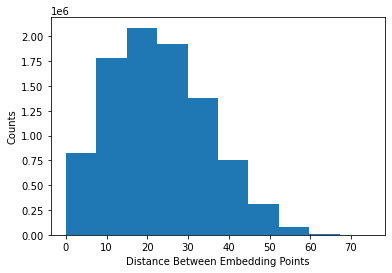

In [303]:
# pairwise_dists = spatial.distance.pdist(embedding, metric=get_metric(p, name=True))
pairwise_dists = spatial.distance.cdist(embedding, embedding, metric=get_metric(p, name=True))
pdist_flat = pairwise_dists.flatten()
plt.hist(pdist_flat)
plt.xlabel('Distance Between Embedding Points')
plt.ylabel('Counts')
plt.show()

In [304]:
pdist_sorted = np.sort(pdist_flat)
print(f"percentile = {np.argmax(pdist_sorted > 10)/len(pdist_sorted):.3f}")

percentile = 0.149


In [305]:
# epsilon = 20
# neighbor_counts = np.zeros(len(embedding))
# for i in range(len(embedding)):
#     for j in range(len(embedding)):
#         if pairwise_dists[i, j] < epsilon:
#             neighbor_counts[i] += 1
# plt.hist(neighbor_counts)
# plt.xlabel('Number of Neighbors')
# plt.ylabel('Count')
# plt.title(fr'Histogram of Neighbor Counts with $\epsilon = $ {epsilon}, m = {m}')
# plt.show()

In [306]:
m_vals = [3]
epsilon_vals = np.linspace(np.percentile(pdist_flat, 12), np.percentile(pdist_flat, 18), 5)
# epsilon_vals = [8, 9, 10]
max_delta = 75
num_reference_pts = 500
p = 1

results = compute_average_neighbor_distance(signal, m_vals, epsilon_vals, max_delta, num_reference_pts, p, progress_bar=True)

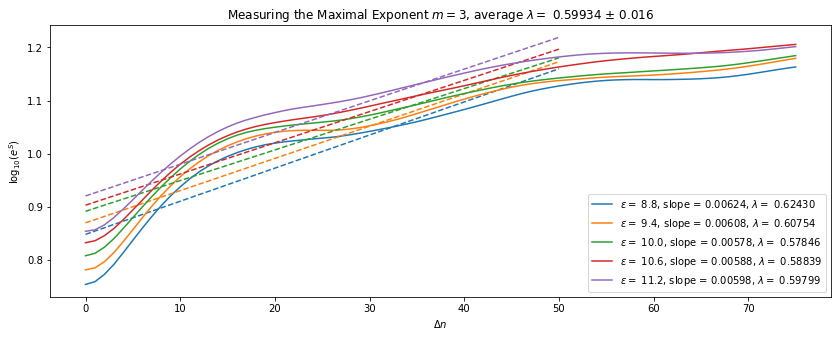

In [307]:
plt.figure(figsize=(14, 5))
for i, m in enumerate(m_vals):
    plt.subplot(1, len(m_vals), i + 1)
    end_linear = [50][i]
    lambdas = []
    for j, result in enumerate(results):
        if result['m'] == m:
            slope, intercept, r_value, p_value, std_err = stats.linregress(result['delta_n'][:end_linear + 1]*dt, np.log10(np.exp(result['S'][:end_linear + 1])))
            lambdas.append(slope)
            plt.plot(result['delta_n'], np.log10(np.exp(result['S'])), label=fr"$\epsilon = $ {result['epsilon']:.1f}, slope = {slope*dt:.5f}, $\lambda = $ {slope:.5f}", c=f"C{j}")
#             plt.plot(result['delta_n'], np.exp(result['S']), label=fr"$\epsilon = $ {result['epsilon']}", c=f"C{j}")
            plt.plot(result['delta_n'][:end_linear+1], result['delta_n'][:end_linear+1]*slope*dt + intercept, linestyle='--', c=f"C{j}")
    plt.xlabel(r'$\Delta n$')
    plt.ylabel(r'$\log_{10}(e^S)$')
    plt.title(rf"Measuring the Maximal Exponent" + f" $m =${m}, average $\lambda = $ {np.mean(lambdas):.5f} $\pm$ {np.std(lambdas):.3f}")
    plt.legend()

plt.show()

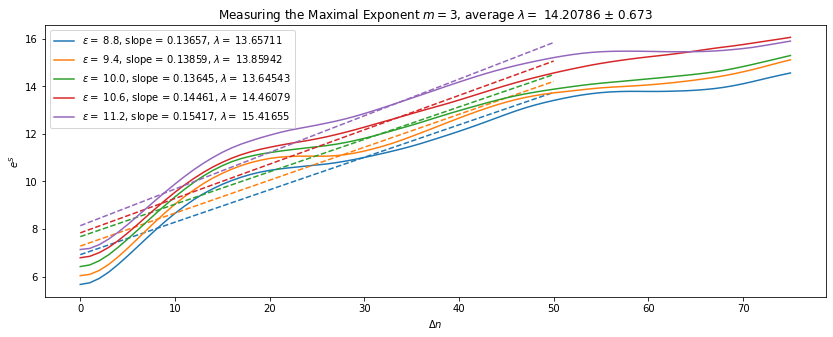

In [308]:
plt.figure(figsize=(14, 5))
end_linear = 50
for i, m in enumerate(m_vals):
    plt.subplot(1, len(m_vals), i + 1)
    lambdas = []
    for j, result in enumerate(results):
        if result['m'] == m:
            slope, intercept, r_value, p_value, std_err = stats.linregress(result['delta_n'][:end_linear + 1]*dt, np.exp(result['S'][:end_linear + 1]))
            lambdas.append(slope)
            plt.plot(result['delta_n'], np.exp(result['S']), label=fr"$\epsilon = $ {result['epsilon']:.1f}, slope = {slope*dt:.5f}, $\lambda = $ {slope:.5f}", c=f"C{j}")
#             plt.plot(result['delta_n'], np.exp(result['S']), label=fr"$\epsilon = $ {result['epsilon']}", c=f"C{j}")
            plt.plot(result['delta_n'][:end_linear+1], result['delta_n'][:end_linear+1]*slope*dt + intercept, linestyle='--', c=f"C{j}")
    plt.xlabel(r'$\Delta n$')
    plt.ylabel(r'$e^S$')
    plt.title(rf"Measuring the Maximal Exponent" + f" $m =${m}, average $\lambda = $ {np.mean(lambdas):.5f} $\pm$ {np.std(lambdas):.3f}")
    plt.legend()

plt.show()

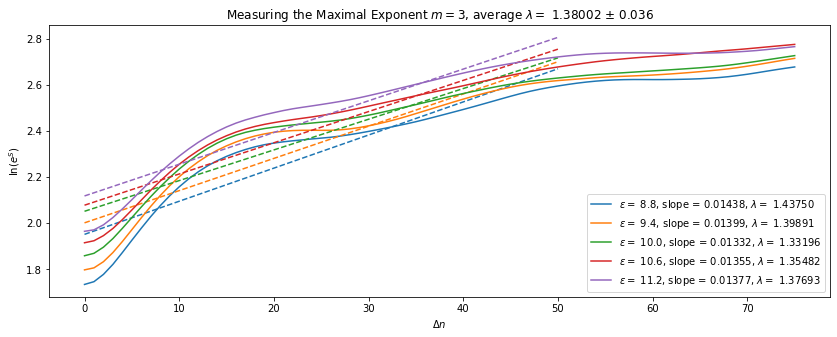

In [309]:
plt.figure(figsize=(14, 5))
end_linear = 50
for i, m in enumerate(m_vals):
    plt.subplot(1, len(m_vals), i + 1)
    lambdas = []
    for j, result in enumerate(results):
        if result['m'] == m:
            slope, intercept, r_value, p_value, std_err = stats.linregress(result['delta_n'][:end_linear + 1]*dt, np.log(np.exp(result['S'][:end_linear + 1])))
            lambdas.append(slope)
            plt.plot(result['delta_n'], np.log(np.exp(result['S'])), label=fr"$\epsilon = $ {result['epsilon']:.1f}, slope = {slope*dt:.5f}, $\lambda = $ {slope:.5f}", c=f"C{j}")
#             plt.plot(result['delta_n'], np.exp(result['S']), label=fr"$\epsilon = $ {result['epsilon']}", c=f"C{j}")
            plt.plot(result['delta_n'][:end_linear+1], result['delta_n'][:end_linear+1]*slope*dt + intercept, linestyle='--', c=f"C{j}")
    plt.xlabel(r'$\Delta n$')
    plt.ylabel(r'$\ln(e^S)$')
    plt.title(rf"Measuring the Maximal Exponent" + f" $m =${m}, average $\lambda = $ {np.mean(lambdas):.5f} $\pm$ {np.std(lambdas):.3f}")
    plt.legend()

plt.show()

In [310]:
# Choose appropriate Theiler window.
window = 60
d = lyapunov.mle_embed(lorenz_pts[:, 0], dim=[m], tau=tau, maxt=300, window=window)[0]
t = np.arange(300)

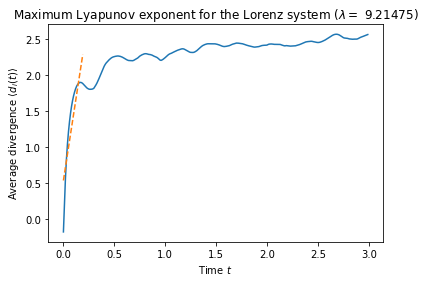

In [315]:
end_linear = 20
slope, intercept, _, _, _ = stats.linregress(dt*t[:end_linear], d[:end_linear])
plt.title(fr'Maximum Lyapunov exponent for the Lorenz system ($\lambda =$ {slope:.5f})')
plt.xlabel(r'Time $t$')
plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.plot(dt * t, d)
plt.plot(dt*t[:end_linear], slope*dt*t[:end_linear] + intercept, linestyle='--')
# plt.plot(dt * t, sample * t * 1, '--')

plt.show()

In [217]:
m_vals = [3]
epsilon_vals = np.linspace(np.percentile(pdist_flat, 12), np.percentile(pdist_flat, 18), 5)
# epsilon_vals = [8, 9, 10]
max_delta = 300
num_reference_pts = 500
p = 1

results = compute_average_neighbor_distance(signal, m_vals, epsilon_vals, max_delta, num_reference_pts, p, progress_bar=True)

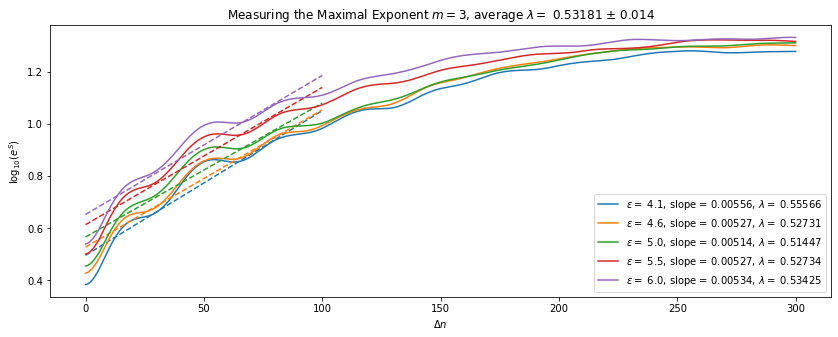

In [222]:
plt.figure(figsize=(14, 5))
for i, m in enumerate(m_vals):
    plt.subplot(1, len(m_vals), i + 1)
    end_linear = [100][i]
    lambdas = []
    for j, result in enumerate(results):
        if result['m'] == m:
            slope, intercept, r_value, p_value, std_err = stats.linregress(result['delta_n'][:end_linear + 1]*dt, np.log10(np.exp(result['S'][:end_linear + 1])))
            lambdas.append(slope)
            plt.plot(result['delta_n'], np.log10(np.exp(result['S'])), label=fr"$\epsilon = $ {result['epsilon']:.1f}, slope = {slope*dt:.5f}, $\lambda = $ {slope:.5f}", c=f"C{j}")
#             plt.plot(result['delta_n'], np.exp(result['S']), label=fr"$\epsilon = $ {result['epsilon']}", c=f"C{j}")
            plt.plot(result['delta_n'][:end_linear+1], result['delta_n'][:end_linear+1]*slope*dt + intercept, linestyle='--', c=f"C{j}")
    plt.xlabel(r'$\Delta n$')
    plt.ylabel(r'$\log_{10}(e^S)$')
    plt.title(rf"Measuring the Maximal Exponent" + f" $m =${m}, average $\lambda = $ {np.mean(lambdas):.5f} $\pm$ {np.std(lambdas):.3f}")
    plt.legend()

plt.show()

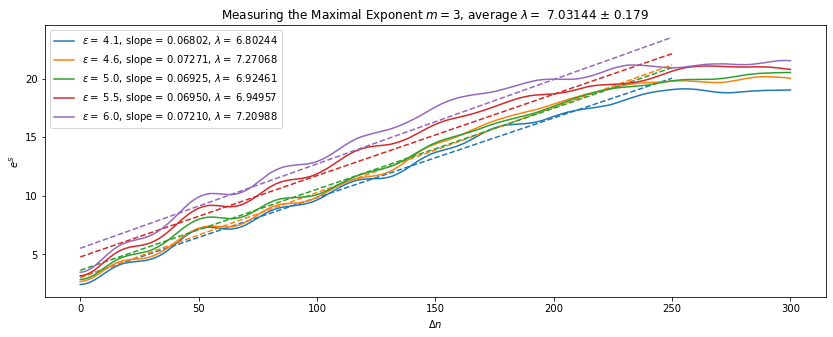

In [234]:
plt.figure(figsize=(14, 5))
end_linear = 250
for i, m in enumerate(m_vals):
    plt.subplot(1, len(m_vals), i + 1)
    lambdas = []
    for j, result in enumerate(results):
        if result['m'] == m:
            slope, intercept, r_value, p_value, std_err = stats.linregress(result['delta_n'][:end_linear + 1]*dt, np.exp(result['S'][:end_linear + 1]))
            lambdas.append(slope)
            plt.plot(result['delta_n'], np.exp(result['S']), label=fr"$\epsilon = $ {result['epsilon']:.1f}, slope = {slope*dt:.5f}, $\lambda = $ {slope:.5f}", c=f"C{j}")
#             plt.plot(result['delta_n'], np.exp(result['S']), label=fr"$\epsilon = $ {result['epsilon']}", c=f"C{j}")
            plt.plot(result['delta_n'][:end_linear+1], result['delta_n'][:end_linear+1]*slope*dt + intercept, linestyle='--', c=f"C{j}")
    plt.xlabel(r'$\Delta n$')
    plt.ylabel(r'$e^S$')
    plt.title(rf"Measuring the Maximal Exponent" + f" $m =${m}, average $\lambda = $ {np.mean(lambdas):.5f} $\pm$ {np.std(lambdas):.3f}")
    plt.legend()

plt.show()

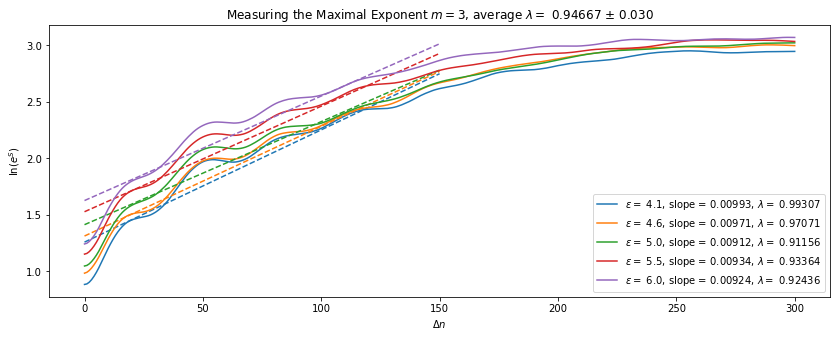

In [232]:
plt.figure(figsize=(14, 5))
end_linear = 150
for i, m in enumerate(m_vals):
    plt.subplot(1, len(m_vals), i + 1)
    lambdas = []
    for j, result in enumerate(results):
        if result['m'] == m:
            slope, intercept, r_value, p_value, std_err = stats.linregress(result['delta_n'][:end_linear + 1]*dt, np.log(np.exp(result['S'][:end_linear + 1])))
            lambdas.append(slope)
            plt.plot(result['delta_n'], np.log(np.exp(result['S'])), label=fr"$\epsilon = $ {result['epsilon']:.1f}, slope = {slope*dt:.5f}, $\lambda = $ {slope:.5f}", c=f"C{j}")
#             plt.plot(result['delta_n'], np.exp(result['S']), label=fr"$\epsilon = $ {result['epsilon']}", c=f"C{j}")
            plt.plot(result['delta_n'][:end_linear+1], result['delta_n'][:end_linear+1]*slope*dt + intercept, linestyle='--', c=f"C{j}")
    plt.xlabel(r'$\Delta n$')
    plt.ylabel(r'$\ln(e^S)$')
    plt.title(rf"Measuring the Maximal Exponent" + f" $m =${m}, average $\lambda = $ {np.mean(lambdas):.5f} $\pm$ {np.std(lambdas):.3f}")
    plt.legend()

plt.show()

# Simulating Baier Klein

In [235]:
# dt, T are in milliseconds
def simulate_baier_klein(T = 5000, initial_condition=None):
    if initial_condition is None:
        initial_condition = np.random.normal(size=(3,))
    
    time_vals = np.arange(0, T + 1)
    pts = np.zeros((len(time_vals), 3))
    pts[0] = initial_condition
    
    for t in range(1, len(time_vals)):
        x, y, z = pts[t - 1]
        x_new = 1.76 - y**2 - 0.1*z
        y_new = x
        z_new = y
        
        pts[t] = [x_new, y_new, z_new]
    
    return pts, time_vals

In [236]:
T = 3000
dt = 1
baier_klein_pts, time_vals = simulate_baier_klein(T=T, initial_condition=(0, 0, 0))

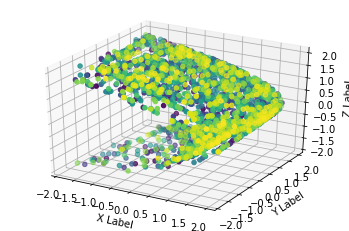

In [237]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(baier_klein_pts[:, 0], baier_klein_pts[:, 1], baier_klein_pts[:, 2], c=time_vals)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

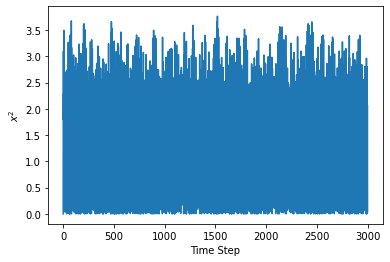

In [238]:
plt.plot(baier_klein_pts[:, 0]**2)
plt.xlabel('Time Step')
plt.ylabel('$x^2$')
plt.show()

In [239]:
signal = baier_klein_pts[:, 0]**2

### Pick Time Lag


The chosen time lag tau = 1 (1.00 seconds)


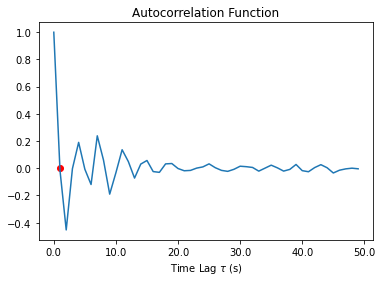

In [240]:
acorr = autocorr(signal, max_lag=None, progress_bar=True)

tau = np.argmax(acorr < 0)
# tau = 12
print(f"The chosen time lag tau = {tau} ({tau*dt:.2f} seconds)")

plt.plot(acorr[:50])
plt.title('Autocorrelation Function')
plt.xlabel(r'Time Lag $\tau$ (s)')
xticks = plt.xticks()[0][1:-1]
plt.xticks(xticks, xticks*dt)
plt.scatter(tau, 0, c='red')
plt.show()

### Pick an Embedding Dimension

In [241]:
m = 3
embedding = embed_signal(signal, m, tau=tau)

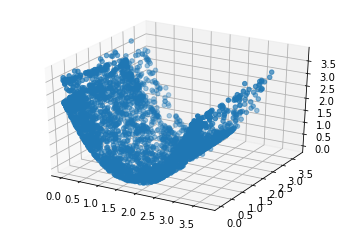

In [242]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
plt.show()

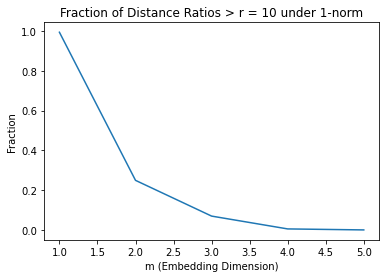

In [243]:
p = 1
r = 10

M_vals = np.arange(1, 6)
fraction_fnn = np.zeros(M_vals.shape)

for i, m in enumerate(M_vals):
    embedding = embed_signal(signal, m, tau=tau)
    nn_indices, _ = get_nn_indices(embedding, p=p)
    fraction_greater, ratios = calculate_fnn_stat(embedding, nn_indices, r, p=p)
    fraction_fnn[i] = fraction_greater

plt.plot(M_vals, fraction_fnn)
plt.xlabel('m (Embedding Dimension)')
plt.title(f'Fraction of Distance Ratios > r = {r} under {p}-norm')
plt.ylabel('Fraction')
plt.show()

### Compute Lyapunov Exponent

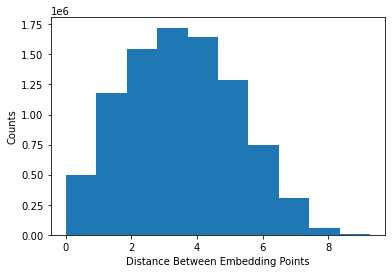

In [244]:
m = 3
p = 1
embedding = embed_signal(signal, m, tau=tau)

# pairwise_dists = spatial.distance.pdist(embedding, metric=get_metric(p, name=True))
pairwise_dists = spatial.distance.cdist(embedding, embedding, metric=get_metric(p, name=True))
pdist_flat = pairwise_dists.flatten()
plt.hist(pdist_flat)
plt.xlabel('Distance Between Embedding Points')
plt.ylabel('Counts')
plt.show()

# pdist_sorted = np.sort(pdist_flat)
# print(f"percentile = {np.argmax(pdist_sorted > 10)/len(pdist_sorted):.3f}")

In [245]:
m_vals = [3]
# epsilon_vals = [3]
epsilon_vals = np.linspace(np.percentile(pdist_flat, 12), np.percentile(pdist_flat, 18), 5)
# epsilon_vals = [2, 4]
max_delta = 50
num_reference_pts = 500
p = 1

results = compute_average_neighbor_distance(signal, m_vals, epsilon_vals, max_delta, num_reference_pts, p, progress_bar=True)

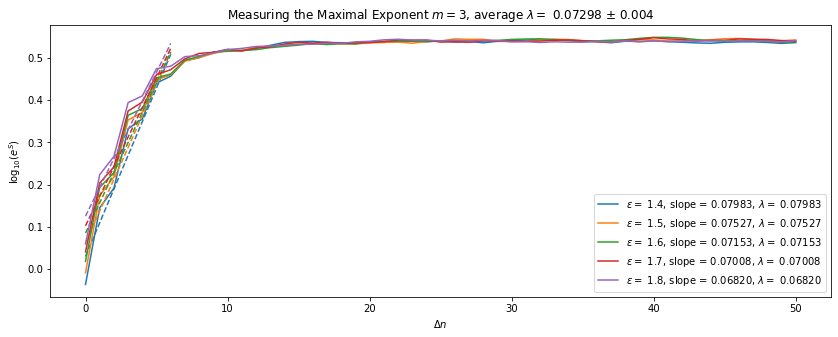

In [246]:
plt.figure(figsize=(14, 5))
for i, m in enumerate(m_vals):
    plt.subplot(1, len(m_vals), i + 1)
    lambdas = []
    end_linear = [6][i]
    for j, result in enumerate(results):
        if result['m'] == m:
            slope, intercept, r_value, p_value, std_err = stats.linregress(result['delta_n'][:end_linear + 1]*dt, np.log10(np.exp(result['S'][:end_linear + 1])))
            lambdas.append(slope)
            plt.plot(result['delta_n'], np.log10(np.exp(result['S'])), label=fr"$\epsilon = $ {result['epsilon']:.1f}, slope = {slope:.5f}, $\lambda = $ {slope/dt:.5f}", c=f"C{j}")
#             plt.plot(result['delta_n'], np.exp(result['S']), label=fr"$\epsilon = $ {result['epsilon']}", c=f"C{j}")
            plt.plot(result['delta_n'][:end_linear+1], result['delta_n'][:end_linear+1]*slope + intercept, linestyle='--', c=f"C{j}")
    plt.xlabel(r'$\Delta n$')
    plt.ylabel(r'$\log_{10}(e^S)$')
    plt.title(rf"Measuring the Maximal Exponent" + f" $m =${m}, average $\lambda = $ {np.mean(lambdas):.5f} $\pm$ {np.std(lambdas):.3f}")
    plt.legend()

plt.show()

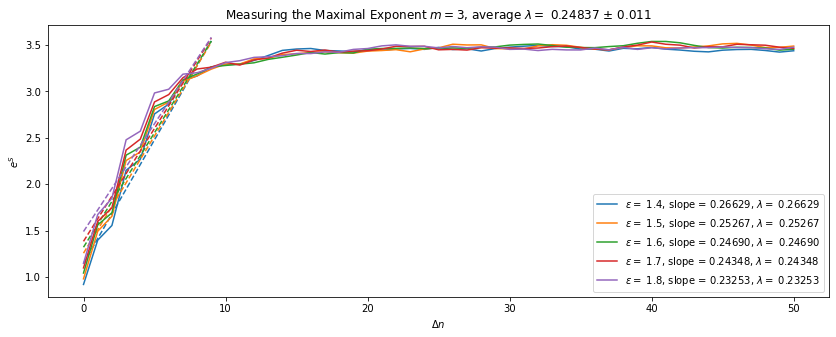

In [254]:
plt.figure(figsize=(14, 5))
end_linear = 9
for i, m in enumerate(m_vals):
    plt.subplot(1, len(m_vals), i + 1)
    lambdas = []
    for j, result in enumerate(results):
        if result['m'] == m:
            slope, intercept, r_value, p_value, std_err = stats.linregress(result['delta_n'][:end_linear + 1]*dt, np.exp(result['S'][:end_linear + 1]))
            lambdas.append(slope)
            plt.plot(result['delta_n'], np.exp(result['S']), label=fr"$\epsilon = $ {result['epsilon']:.1f}, slope = {slope*dt:.5f}, $\lambda = $ {slope:.5f}", c=f"C{j}")
#             plt.plot(result['delta_n'], np.exp(result['S']), label=fr"$\epsilon = $ {result['epsilon']}", c=f"C{j}")
            plt.plot(result['delta_n'][:end_linear+1], result['delta_n'][:end_linear+1]*slope*dt + intercept, linestyle='--', c=f"C{j}")
    plt.xlabel(r'$\Delta n$')
    plt.ylabel(r'$e^S$')
    plt.title(rf"Measuring the Maximal Exponent" + f" $m =${m}, average $\lambda = $ {np.mean(lambdas):.5f} $\pm$ {np.std(lambdas):.3f}")
    plt.legend()

plt.show()

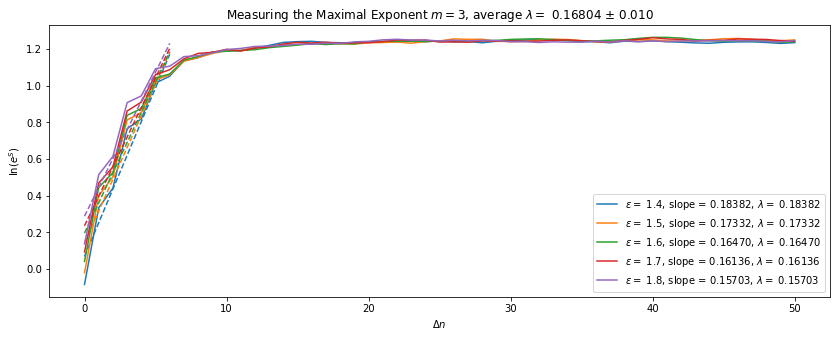

In [253]:
plt.figure(figsize=(14, 5))
end_linear = 6
for i, m in enumerate(m_vals):
    plt.subplot(1, len(m_vals), i + 1)
    lambdas = []
    for j, result in enumerate(results):
        if result['m'] == m:
            slope, intercept, r_value, p_value, std_err = stats.linregress(result['delta_n'][:end_linear + 1]*dt, np.log(np.exp(result['S'][:end_linear + 1])))
            lambdas.append(slope)
            plt.plot(result['delta_n'], np.log(np.exp(result['S'])), label=fr"$\epsilon = $ {result['epsilon']:.1f}, slope = {slope*dt:.5f}, $\lambda = $ {slope:.5f}", c=f"C{j}")
#             plt.plot(result['delta_n'], np.exp(result['S']), label=fr"$\epsilon = $ {result['epsilon']}", c=f"C{j}")
            plt.plot(result['delta_n'][:end_linear+1], result['delta_n'][:end_linear+1]*slope*dt + intercept, linestyle='--', c=f"C{j}")
    plt.xlabel(r'$\Delta n$')
    plt.ylabel(r'$\ln(e^S)$')
    plt.title(rf"Measuring the Maximal Exponent" + f" $m =${m}, average $\lambda = $ {np.mean(lambdas):.5f} $\pm$ {np.std(lambdas):.3f}")
    plt.legend()

plt.show()

In [258]:
# Choose appropriate Theiler window.
window = 40
d = lyapunov.mle_embed(baier_klein_pts[:, 0]**2, dim=[m], tau=tau, maxt=300, window=window)[0]
t = np.arange(300)

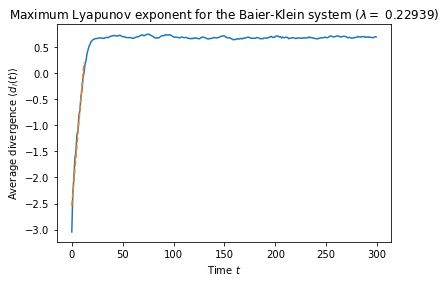

In [270]:
end_linear = 13
slope, intercept, _, _, _ = stats.linregress(dt*t[:end_linear], d[:end_linear])
plt.title(fr'Maximum Lyapunov exponent for the Baier-Klein system ($\lambda =$ {slope:.5f})')
plt.xlabel(r'Time $t$')
plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.plot(dt * t, d)
plt.plot(dt*t[:end_linear], slope*dt*t[:end_linear] + intercept, linestyle='--')
# plt.plot(dt * t, sample * t * 1, '--')

plt.show()

## nolitsa

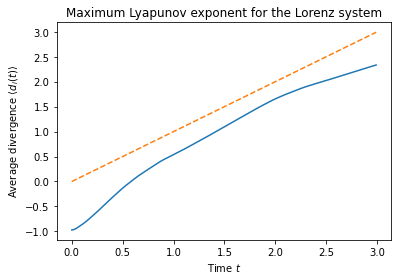

In [88]:
from nolitsa import data, lyapunov
import numpy as np
import matplotlib.pyplot as plt

sample = 0.01
x0 = [0.62225717, -0.08232857, 30.60845379]
x = data.lorenz(length=5000, sample=sample, x0=x0,
                sigma=10, beta=8/3, rho=28)[1][:, 0]

# Choose appropriate Theiler window.
window = 60

# Time delay.
tau = 13

# Embedding dimension.
dim = [5]

d = lyapunov.mle_embed(x, dim=dim, tau=tau, maxt=300, window=window)[0]
t = np.arange(300)

plt.title('Maximum Lyapunov exponent for the Lorenz system')
plt.xlabel(r'Time $t$')
plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.plot(sample * t, d)
plt.plot(sample * t, sample * t * 1, '--')

plt.show()

In [208]:
x.shape

(5000,)